# Optimizador Noam

Vaswani et al. (2017) proponen un mecanismo de optimización que, afirman, mejora el proceso de aprendizaje de los parámetros durante el entrenamiento del modelo de transformador. Este optimizador está basado en el optimizador Adam, que es un estándar en el entrenamiento de redes neuronales. Este optimizador, entonces, busca ajustar la tasa de aprendizaje para que éste se adapte a la convergencia hacia el mínimo de la función objetivo. Para entrar en detalle con el optimizador Noam, veamos antes los detalles de Adam.

## Adam

El optimizador Adam (Kingma & Ba, 2014) es un optimizador que a su vez se basa en otros dos optimizadores: 1) el optimizador adagrad (del inglés <it>adaptative gradient</it> (de donde viene "ada"; y 2) del método del momentum (de donde viene la "m"). Es decir, incorpora un gradiente adaptativo y un momentum a la regla de actualización de los parámetros. Recordemos que el método de gradiente descendiente actualiza los parámetros $\theta$ (que en este caso son nuestros pesos en las matrices y los bias), dada una función objetivo $R(\theta)$, a partir de la siguiente regla:

$$\theta \leftarrow \theta - \eta \nabla R(\theta)$$

En el optimizador Adam, se proponen dos nuevos parámetros $\hat{\mu}$ y $\hat{\nu}$ que se estiman, al mismo, tiempo a partir de los valores de $\mu$ y $\nu$. Estos dos valores se calculan como:

$$\mu \leftarrow \beta_1 \mu + (1-\beta_1) \nabla R(\theta)$$
$$\nu \leftarrow \beta_2 \nu + (1-\beta_2)|\nabla R(\theta)|^2$$

Donde $\beta_1, \beta_2 \in [0,1]$ son hiperparámetros, generalmente configurados como $\beta_1= 0.9$ y $\beta_2 = 0.98$. Como se puede observar, ambas ecuaciones son sumas convexas de el valor en el paso anterior y de un factor que tiene que ver con el gradiente de la función objetivo. 

Como señalábamos, Adam tiene una aplicación del momentum, que corresponde al valor de $\mu$. En este caso, los valores $\mu$ van acumulando los gradientes en los pasos anteriores, de tal forma que tenemos la suma de un momentum dado como $\nabla R(\theta) + \mu$, interpretando $\mu$ como el momentum. En este caso, $\beta_1$ simplemente pondera ambos factores de manera convexa.
Por su parte, $\nu$ sirve para adaptar el gradiente; es decir, lo usaremos para dividir al gradiente y que este se adapte según el tamaño del gradiente. Por tanto, este valor toma el gradiente al cuadrado que va a escalar la tasa de aprendizaje.

Antes de aplicar estos valores al optimizador, se realiza una normalización de éstos de la siguiente forma:

$$\hat{\mu} = \frac{\mu}{1-\beta_1}$$
$$\hat{\nu} = \frac{\nu}{1-\beta_2}$$

De aquí se puede observar que si $\beta_1 = 0 = \beta_2$ el optimizador sólo adaptará el gradiente con respecto a $|\nabla R(\theta)|^2$. Haciendo los valores de $\beta_1$ y $\beta_2$ más cercanos a 1, lo que hará es que la influencia estará mayormente en los gradientes de los pasos previos, pero la influencia de estos será pequeña (de orden $1-\beta$). Finalmente, el optimizador Adam utiliza la regla de actualización:

$$\theta \leftarrow \theta - \frac{\eta}{\hat{\nu} + \epsilon} \hat{\mu}$$

Como señalábamos $\hat{\nu}$ se utiliza para adapatar la tasa de aprendizaje, dividiendo entre este factor más un valor $\epsilon$ que evita divisiones entre 0. El factor $\hat{\mu}$ reemplaza al gradiente, por el valor del gradiente más el momento. El otpimizador Adam ha probado tener mejor desempeño que otros otpimizadores, además de que puede simular a Adagrad cuando las betas son 0.

## Detalles del optimizador Noam

El optimizador Noam está basado en Adam, y lo incorpora dentro de este mismo optimizador. Sin embargo, hace una adaptación de la tasa de apendizaje de una forma distinta a Adam. 

$$\eta = \frac{1}{\sqrt{d}} \min\{ \frac{1}{\sqrt{t}}, \frac{t}{\sqrt{\omega^3}}\}$$

En este caso, la adaptatibilidad de la tasa de aprendizaje depende de $t$ que refiere al paso del entrenamiento, de la dimensión del modelo $d$ y finalmente del hiperparámetro $\omega$ que se conoce como <b>warmup</b>. Vaswani et al. (2017) proponen que $\omega = 4000$, esto lo determinan de manera empírica.

Para observar el comportamiento de la tasa de aprendizaje con respecto al optmizador Noam, podemos graficar los valores para un número de pasos creciente, tomamos la dimensión del modelo $d=256$.

<img src="images/NoamGraph.png" width="450" class="center">

En este caso, las primeras iteraciones tienen un crecimiento casi lineal, mientras que después decrece aunque de manera lenta conforme se avanza en cada paso. De esta forma, la actualización de los pesos con optimizador Noam incorpora el momentum de Adam, pero modifica la adaptatibilidad de la tasa de aprendizaje. 

Para implementar el optimizador Noam, generamos una clase que se comporte como un optimizador de PyTorch. Definimos el valor de warump, así como otros hiperparámetros. Utilizamos dentro de la clase al optimizador Adam. Definimos también una función <tt>rate</tt> que estima la tasa de aprendizaje con respecto a la formulación arriba expuesta. Asimismo, definimos las funciones de <tt>step</tt> y <tt>zero_grad</tt> propias de un optimizador en PyTorch.

In [1]:
import torch
import torch.nn as nn
import numpy as np

class NoamOptimizer:
    def __init__(self, parameters, d_model, warmup=40000, init_lr=0, eps=1e-9, decay=0.01):
        #optimizador
        self.optimizer = torch.optim.Adam(parameters, lr=init_lr, betas=(0.9, 0.98), eps=eps, weight_decay=decay)
        self._step = 0
        self.warmup = warmup
        self.model_size = d_model
        self._rate = 0
        
    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self):
        step = self._step
        lr_step = self.model_size**(-0.5) * min(step**(-0.5), step*self.warmup**(-1.5))
        return lr_step

    def zero_grad(self):
        self.optimizer.zero_grad()

## Prueba del optimizador

Para probar el optimizador definimos el mismo problema de un modelo del lenguaje por medio de auto-atención con enmascaramiento en las palabras subsecuentes. De igual forma que en los casos pasados, definimos un dataset de entrenamiento y determinamos el modelo con los hiperparámetros necesarios:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap as hm
from tqdm import tqdm
from transformers import *
from transformers import *
import copy

class MultiHeadMaskAttention(nn.Module):
    def __init__(self, in_size, d_model, hidden=128, heads=3, dropout=0.3):
        super(MultiHeadMaskAttention, self).__init__()
        self.d_model = d_model
        #Embedding y codificación posicional
        self.enc = Encoding(in_size, d_model)
        #Auto-atención enmascarada
        self.att = nn.ModuleList([copy.deepcopy(MaskAttention(d_model)) for _ in range(heads)])
        #Capa linear para multi cabezas
        self.lin = nn.Linear(heads*d_model, d_model, bias=True)
        #Normalización
        self.norm = LayerNorm(d_model)
        #Red feedforward
        self.ffw = nn.Sequential(nn.Linear(d_model, hidden), nn.ReLU(),
                                nn.Linear(hidden, d_model))
        self.drop1 = nn.Dropout(p=dropout)
        self.drop2 = nn.Dropout(p=dropout)
        self.drop3 = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x_e = self.enc(x)
        x_e = self.drop1(x_e)
        head_att = [head(x_e) for head in self.att]
        self.att_weights = [head[1] for head in head_att]
        heads = [head[0] for head in head_att]
        multi_heads = torch.cat(heads, dim=-1)
        h = self.lin(multi_heads)
        h_norm = x_e + self.norm(h)
        h_norm = self.drop2(h_norm)
        out = self.ffw(h)
        
        return self.drop3(h_norm + self.norm(out))

In [4]:
#Corpus a utilizar
corpus = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
          'un perro come croquetas', 'el perro come', 'el gato come croquetas', 
          'un gato come', 'un muchacho jugaba con la cuerda', 'el muchacho jugaba con la cuerda']
corpus = [w.split() for w in corpus]
#Creación del vocabulario
voc = vocab()
voc['[bos]'] = 0
voc['[eos]'] = 1
#Indexación de cadenas
sents = list(index(corpus, voc))

#Pares de entrenamiento
x = [torch.cat((torch.tensor([voc['[bos]']]),s), axis=0) for s in sents]
y = [torch.cat((s, torch.tensor([voc['[eos]']])), axis=0) for s in sents]

In [5]:
len_voc = len(voc)
model = nn.Sequential(MultiHeadMaskAttention(len_voc, 128, heads=5), 
                      nn.Linear(128,len_voc), nn.Softmax(1)) 

#Carga del modelo
#model_heads.load_state_dict(torch.load('noam_model.model'))
#model_heads.eval()

Ahora procedemos a entrenar el modelo. En este caso, el procedimiento es similar a los casos anteriores y a cualquier entrenamiento de PyTorch, pero utilizamos el optimizador Noam. A este le damos los parámetros del modelo que debe optimizar, así como la dimensión del modelo que utiliza para la adaptación de la tasa de aprendizaje. En este caso, no usamos regularización por weigth decay, por lo que le asignamos un valor de 0.

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = NoamOptimizer(model.parameters(), model[0].d_model, decay=0)
epochs = range(300)

#Entrenamiento
model.train()
for t in tqdm(epochs):
    for i in torch.randperm(len(x)):
        prediction = model(x[i])
        optimizer.zero_grad()
        loss_value = criterion(prediction, y[i])
        loss_value.backward()
        optimizer.step()

/home/cienciasia/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
100%|█████████████████████████████████████████| 300/300 [00:43<00:00,  6.96it/s]


### Exploración del modelo

Al igual que en los casos anteriores, podemos ver qué es lo que aprende el modelo a partir de las probabilidades que se obtienen y de sus matrices de atención. En este caso, esperaríamos que con el optimizador Noam los modelos aprendidos fueran más adecuados, aunque hay que señalar que todavía falta una parte importante de los grandes modelos del lenguaje que son las grandes cantidades de datos, pues hasta ahora sólo estamos probando los modelos con datos de juguete.

Palabra siguiente con mayor prob: el


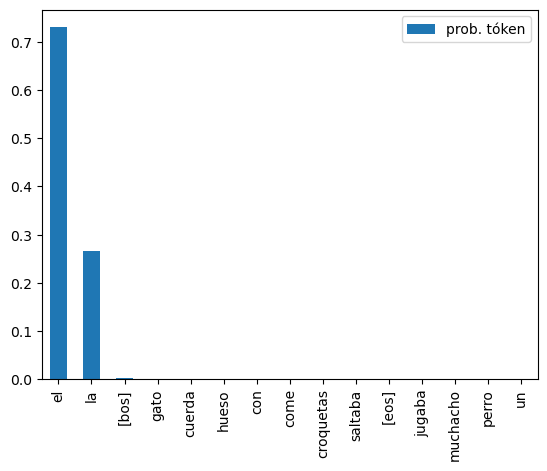

In [7]:
devoc = {i:t for t,i in voc.items()}
def result(text, model):
    #Función para predecir la siguiente palabra dado el contexto
    tokens = text.split()
    x = torch.tensor([voc[t] for t in tokens])
    pred = model(x)
    max_token = pred.argmax(axis=1).detach().numpy()
    
    return pred.detach().numpy(), ' '.join([devoc[i] for i in max_token])

p, pred_text = result('[bos]', model)
print('Palabra siguiente con mayor prob: {}'.format(pred_text))

#Visualización de probabilidades más altas
args = np.argsort(p[-1])[::-1]
probs = np.sort(p[-1])[::-1]
pd.DataFrame(data=probs, columns=['prob. tóken'], index=[devoc[j] for j in args]).plot.bar()
plt.show()

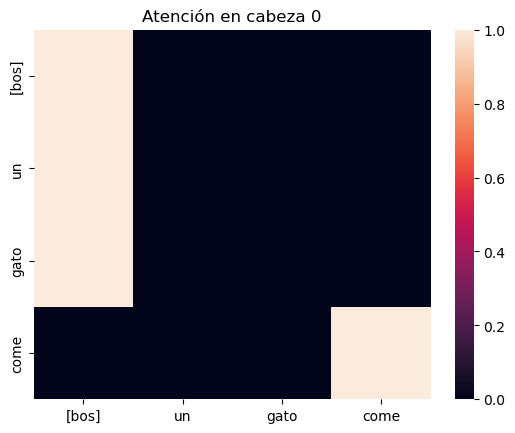

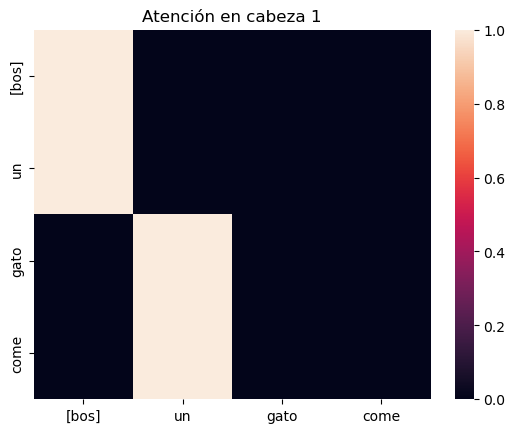

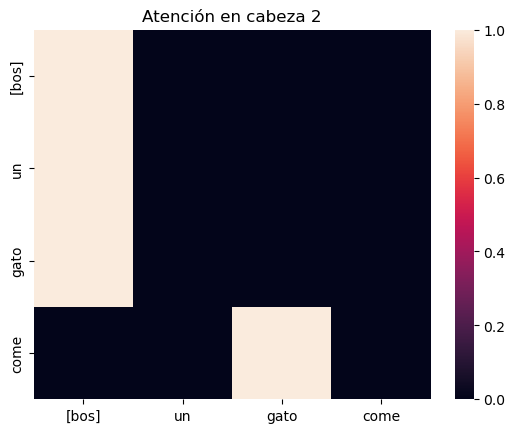

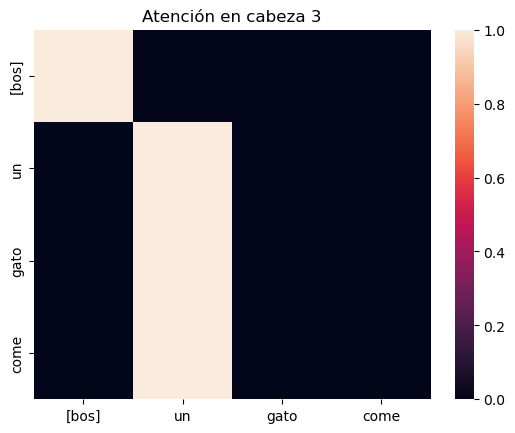

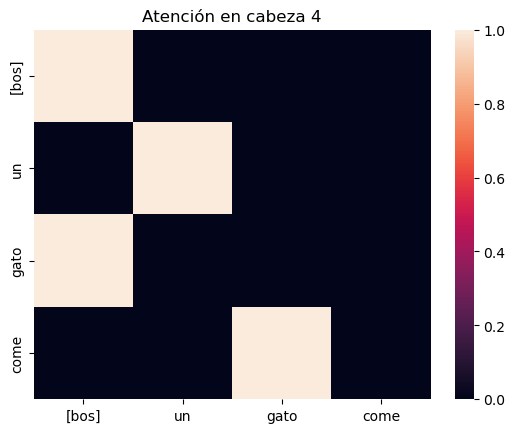

In [8]:
text = '[bos] un gato come'
result(text, model)

for i, att_w in enumerate(model[0].att_weights):
    hm(att_w.detach().numpy(), xticklabels=text.split(), yticklabels=text.split(), vmin=0, vmax=1)
    plt.title('Atención en cabeza %i' %i)
    plt.show()

## Referencias

Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). <it>Attention is all you need. Advances in neural information processing systems</it>, 30.

-----------------------------------------------------------------------

<a href="https://victormijangosdelacruz.github.io/MecanismosAtencion/">Principal</a>